# PRACTICA 1 - Pabloff Garza Rodolfo

In [1]:
import sys
sys.path.append('tsp')
import os
from os import path, listdir
from tsp import benchmarks,metrics,tspplot
from tsp.tspobject import TSPObject

benchmark_path = r'benchmarks'

# Algoritmo Murcielago

In [2]:
import random
import numpy as np

#*************************************Funciones*************************************
def random_tour(O):
    names = O.V
    return list(np.random.permutation(names))

def swap_2opt(tour, nodos):
    i = random.randrange(nodos)
    j = random.randrange(i + 1, nodos + 1)
    
    nuevo_tour = tour[0:i]
    nuevo_tour.extend(reversed(tour[i:j+1]))
    nuevo_tour.extend(tour[j+1:])
    return nuevo_tour

def swap_3opt(O,t,nodos, n=[]):
    tour = t[:]
    
    i = random.randrange(1, nodos - 1)
    j = random.randrange(i + 1, nodos)
    k = random.randrange(j + 1, nodos + 1)
    
    A,B,C,D,E,F = tour[i-1],tour[i],tour[j-1],tour[j],tour[k-1],tour[k%len(tour)]
    d0 = O._M[A][B] + O._M[C][D] + O._M[E][F]
    d1 = O._M[A][C] + O._M[B][D] + O._M[E][F]
    d2 = O._M[A][B] + O._M[C][E] + O._M[D][F]
    d3 = O._M[F][B] + O._M[C][D] + O._M[E][A]
    d4 = O._M[F][B] + O._M[C][E] + O._M[D][A]
    d5 = O._M[F][C] + O._M[B][D] + O._M[E][A]
    d6 = O._M[A][C] + O._M[B][E] + O._M[D][F]
    d7 = O._M[A][D] + O._M[E][B] + O._M[C][F]
    d = [d0,d1,d2,d3,d4,d5,d6,d7]
    # Elegir Mejor Intercambio
    m = np.argmin(d)
    # Intercambio Aleatorio
    #m = np.random.randint(1,len(d))
    if m == 1:
        tour[i:j] = reversed(tour[i:j])
    elif m == 2:
        tour[j:k] = reversed(tour[j:k])
    elif m == 3:
        tour[i:k] = reversed(tour[i:k])
    elif m == 4:
        tour[j:k] = reversed(tour[j:k])
        tour[i:k] = reversed(tour[i:k])
    elif m == 5:
        tour[i:j] = reversed(tour[i:j])
        tour[i:k] = reversed(tour[i:k])
    elif m == 6:
        tour[i:j] = reversed(tour[i:j])
        tour[j:k] = reversed(tour[j:k])
    elif m == 7:
        tour[i:k] = tour[j:k] + tour[i:j]
    return tour

def dist_Hamming(tour1, tour2, tamano):
    distancia = 0
    for i in range(tamano):
        if(tour1[i] is not tour2[i]):
            distancia += 1
    return distancia

def bat_algorithm(tsp_data, iteraciones, tam_poblacion):
    #*********************************Iniciar poblacion*********************************
    parametros = ['tour','pulse_rate','velocity','loudness']
    murcielagos = []

    for i in range(tam_poblacion):
        murcielagos.append({nombre:{} for nombre in parametros})
        murcielagos[i]['tour'] = random_tour(tsp_data)
        murcielagos[i]['pulse_rate'] = 0
        murcielagos[i]['velocity'] = random.randrange(10)
        murcielagos[i]['loudness'] = 1

    murcielagos = sorted(murcielagos, key=lambda murcielago: tsp_data.evaluate_tour(murcielago['tour']))

    #*********************************Iniciar algoritmo*********************************
    for iteracion in range(iteraciones):
        for contador in range(1, len(murcielagos)):
            murcielagos[contador]['velocity'] = random.randrange(1, dist_Hamming(murcielagos[0]['tour'],murcielagos[contador]['tour'], len(tsp_data.V)) + 2)
            if(murcielagos[contador]['velocity'] < len(tsp_data.V) / 2):
                #print("\nEntro a 2-opt con ", murcielagos[contador]['velocity'])

                nuevos = []
                for i in range(murcielagos[contador]['velocity']):
                    nuevos.append(swap_2opt(murcielagos[contador]['tour'], len(tsp_data.V)))
                nuevos = sorted(nuevos, key=lambda murcielago: tsp_data.evaluate_tour(murcielago))

                murcielagos[contador]['tour'] = nuevos[0]

            else:
                #print("\nEntro a 3-opt con ", murcielagos[contador]['velocity'])

                nuevos = []
                for i in range(murcielagos[contador]['velocity']):
                    nuevos.append(swap_3opt(tsp_data, murcielagos[contador]['tour'], len(tsp_data.V)))
                nuevos = sorted(nuevos, key=lambda murcielago: tsp_data.evaluate_tour(murcielago))

                murcielagos[contador]['tour'] = nuevos[0]

            aleatorio = round(random.random(), 1)
            if(aleatorio > murcielagos[contador]['pulse_rate']):
                #print("\nEntro al primer aleatorio: generar solucion entre mejores")

                aleatorio = random.randrange(tam_poblacion)
                murcielagos[-1]['tour'] = swap_2opt(murcielagos[0]['tour'], len(tsp_data.V))
                murcielagos = sorted(murcielagos, key=lambda murcielago: tsp_data.evaluate_tour(murcielago['tour']))

            aleatorio = round(random.random(), 1)
            if(aleatorio < murcielagos[contador]['loudness'] and tsp_data.evaluate_tour(murcielagos[contador]['tour']) < tsp_data.evaluate_tour(murcielagos[0]['tour'])):
                #print("\nEntro al segundo aleatorio: generar solucion aleatoria")

                murcielagos[-1]['tour'] = swap_2opt(murcielagos[0]['tour'], len(tsp_data.V))
                murcielagos = sorted(murcielagos, key=lambda murcielago: tsp_data.evaluate_tour(murcielago['tour']))

                murcielagos[contador]['pulse_rate'] = round(murcielagos[contador]['pulse_rate'] + 0.1, 1)
                murcielagos[contador]['loudness'] = round(murcielagos[contador]['loudness'] - 0.1, 1)

            murcielagos = sorted(murcielagos, key=lambda murcielago: tsp_data.evaluate_tour(murcielago['tour']))
    
    return murcielagos[0]['tour']

# Encontrar una solución a TSP

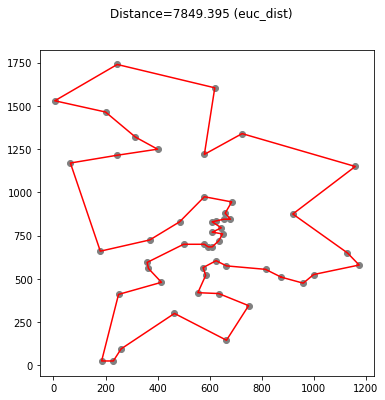

In [6]:
tsp_data = path.join(benchmark_path,'berlin52.tsp')

#Crear Objeto TSP
O = TSPObject(tsp_data,metrics.euc_dist)

#Crear Matriz de Distancias
O.M()

#Crear variable que contenga el numero de nodos
nodos = len(O.V)

#Solucion encontrada por Algoritmo Murcielago
tspplot.plot_tsp(O,bat_algorithm(O, 400, 15),figsize=(6,6))